<a href="https://colab.research.google.com/github/bushio/keras_tutorial/blob/main/notebook/cifar10_DataGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#本ノートの目的
- cifar10データセットがどのようなものかを知る
- 10クラスの画像分類でのCNNの学習を体験する
- mnist との精度の違いを体験する。
- Datageneratorの使い方を知る
- データオーグメンテーションがどういうものかを知る
- データオーグメンテーションの効果を体験する

# [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)
- Kerasの[CIFAR10](https://keras.io/ja/datasets/)について
本ノートの目的

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, InputLayer,Flatten
from tensorflow.keras.optimizers import SGD
import numpy as np

#入力パラメータの設定
- input_height: 入力画像の高さ
- input_width: 入力画像の幅
- input_channel: 入力画像のチャネル数

In [2]:
input_heihgt = 32
input_width = 32
input_channel = 3

#データの準備
- cifar10.load_data() : CIFAR10をダウンロード、訓練データとテストデータを分割する関数
- 前処理として入力画像の正規化(255割り)を行う
-  tf.keras.utils.to_categorical(D, N): DをN次元のone hotな配列にする 
- 10クラス分類なため,10次元のデータにする

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
x_train  = X_train.astype('float32')
x_test   = X_test.astype('float32')
y_train  = tf.keras.utils.to_categorical(y_train, 10)
y_test   = tf.keras.utils.to_categorical(y_test, 10)

170508288/170498071 [==============================] - 3s 0us/step


#モデルの定義
- mnist と同様に下記の構造のCNNを使用する。
  - conv2D x 2
  - MaxPooling2D
  - Dropout
  - Dense
  - Dropout
  - Dense
  - Softmax

In [4]:
def cifar10_cnn(input_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  return model 

model = cifar10_cnn((input_heihgt,input_width,input_channel))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                        

#学習パラメータの設定
- epochs: エポック数（学習データを入力する回数)
- batch_size: バッチサイズ
- loss: [誤差関数](https://keras.io/ja/losses/)
- optimizer: [最適化アルゴリズム](https://keras.io/ja/optimizers/)　
- metrics: [評価関数](https://keras.io/ja/metrics/)

In [5]:
epochs = 100
batch_size = 128
loss = 'categorical_crossentropy'
optimizer = 'rmsprop'
metrics = 'accuracy'

#コールバック
- [コールバック関数](https://keras.io/ja/callbacks/)

In [7]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

eary_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')
callbacks=[eary_stopping,model_checkpoint_callback]

#DataGenerator の定義
- [DataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) を用いた学習データの入力を行う
- DataGenerator の役割
  - イテレーションごとに入力バッチを作成
  - 前処理の実行
  - データオーグメンテーションをリアルタイムに実行
- 実行するデータオーグメンテーション
  - width_shift_range: ランダムな水平シフト(値はシフトする範囲)
  - height_shift_range: ランダムな垂直シフト(値はシフトする範囲)
  - horizontal_flip: ランダムに左右反転
  - rotation_range: ランダムに画像を回転　（値は回転する範囲)
- 実行する前処理:
  - rescale: スケーリング (値を入力データに掛け合わせる)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagenerator = train_datagen.flow(
    x_train,
    y=y_train,
    batch_size=batch_size,
    shuffle=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagenerator = train_datagen.flow(
    x_test,
    y=y_test,
    batch_size=8,
)

#学習の実行




In [ ]:
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
history = model.fit(train_datagenerator,
         validation_data=test_datagenerator,
         steps_per_epoch=len(x_train) / batch_size, epochs=epochs)


Epoch 1/100
390/390 [==============================] - 38s 70ms/step - loss: 1.9075 - accuracy: 0.3070 - val_loss: 1.6295 - val_accuracy: 0.4305
Epoch 2/100
390/390 [==============================] - 27s 70ms/step - loss: 1.6456 - accuracy: 0.4077 - val_loss: 1.4477 - val_accuracy: 0.4731
Epoch 3/100
390/390 [==============================] - 27s 70ms/step - loss: 1.5559 - accuracy: 0.4452 - val_loss: 1.4797 - val_accuracy: 0.4842
Epoch 4/100
390/390 [==============================] - 27s 69ms/step - loss: 1.4882 - accuracy: 0.4683 - val_loss: 1.3351 - val_accuracy: 0.5267
Epoch 5/100
390/390 [==============================] - 27s 70ms/step - loss: 1.4388 - accuracy: 0.4881 - val_loss: 1.2742 - val_accuracy: 0.5413
Epoch 6/100
390/390 [==============================] - 27s 70ms/step - loss: 1.4099 - accuracy: 0.4985 - val_loss: 1.3407 - val_accuracy: 0.5268
Epoch 7/100
390/390 [==============================] - 27s 70ms/step - loss: 1.3928 - accuracy: 0.5057 - val_loss: 1.2437 - val_ac

# 学習結果の検証

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.9617 - accuracy: 0.6844
Test loss: 0.9616636037826538
Test accuracy: 0.6844000220298767


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
CIFAR10_LABELS_LIST = ['airplane',
                       'automobile',
                       'bird',
                       'cat',
                       'deer',
                       'dog',
                       'frog',
                       'horse',
                       'ship',
                       'truck']

predicted label: truck


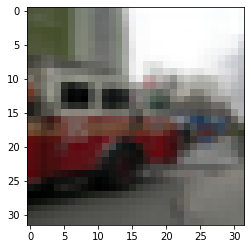

In [ ]:
ind=np.random.randint(0,10000)
test_img = X_test[ind]
predict_img = x_test[ind].reshape(1,32,32,3)
label=np.argmax(y_test[ind])
plt.imshow(test_img)
predictions = model.predict(predict_img)
predicted_label=np.argmax(predictions)
print("predicted label: {}".format(CIFAR10_LABELS_LIST[predicted_label]))

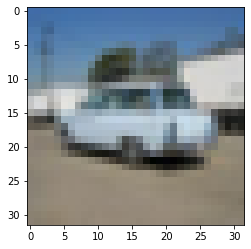

true label: automobile
predicted label: automobile


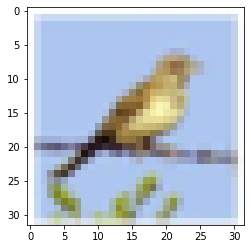

true label: bird
predicted label: bird


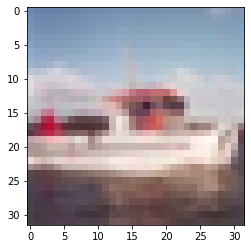

true label: ship
predicted label: ship


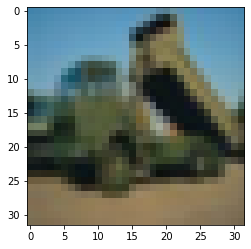

true label: truck
predicted label: truck


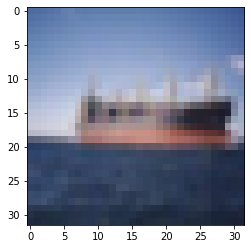

true label: ship
predicted label: ship


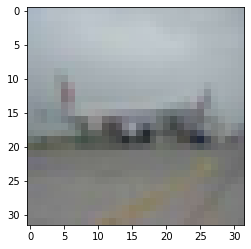

true label: airplane
predicted label: airplane


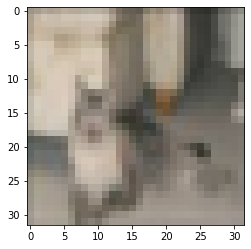

true label: cat
predicted label: cat


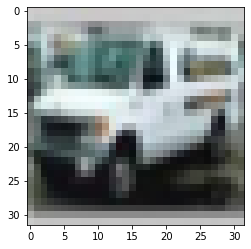

true label: truck
predicted label: automobile


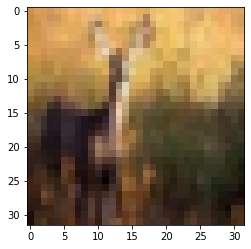

true label: deer
predicted label: deer


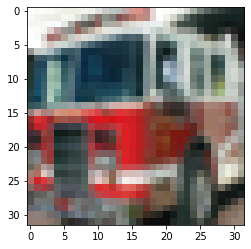

true label: truck
predicted label: truck


In [ ]:
test_image = 10
for i in range(test_image):
  ind=np.random.randint(0,10000)
  test_img = X_test[ind]
  predict_img = x_test[ind].reshape(1,32,32,3)
  label=np.argmax(y_test[ind])
  plt.imshow(test_img)
  plt.show()
  predictions = model.predict(predict_img)
  predicted_label=np.argmax(predictions)
  print("true label: {}".format(CIFAR10_LABELS_LIST[label]))
  print("predicted label: {}".format(CIFAR10_LABELS_LIST[predicted_label]))


#考察
- 精度: 68.4%